### A place to test xgboost and scikit-learn API functionality

In [5]:
import xgboost as xgb
import sklearn
import pandas as pd
import numpy as np
import datetime as dt
import matplotlib as mpl
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.io import shapereader
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
import ipympl
import seaborn as sns
import useful_functions
print('Using xgboost version %s' % xgb.__version__)
print('Using scikit-learn version %s' % sklearn.__version__)
%matplotlib widget

Using xgboost version 1.4.2
Using scikit-learn version 1.0


## **We are gonig predict chance of graduate school admission from 7 student metrics**

Independent variables : GRE Score (int), TOEFL Score (int), University Rating (int, 1-5), SOP (float), LOR (float), CGPA (float), Research (binary)
Dependent variable: Chance of admission (float, 0-1)

The order of operations is designed to reflect the NO2 XGBoost workflow

In [6]:
# load test practice admissions data (must use 'raw' link for URLs)
DATA_LOCATION = 'https://raw.githubusercontent.com/Faroja/Machine-Learning-Practice-5/main/Admission_Predict.csv'
in_data = pd.read_csv(DATA_LOCATION)
in_data.drop('Serial No.', inplace=True, axis=1)

# standardize column headers
for col in list(in_data.columns):
        if in_data[col].dtypes == object:
            in_data[col].replace(' ', '_', regex=True, inplace=True)
        if ' ' in str(col)[:-1]:
            new = str(col).replace(' ', '_')
            if new[-1] == '_':
                new = new[:-1]
            in_data.rename(columns={str(col): new}, inplace=True)
        
            
in_data.head()

GRE_Score  TOEFL_Score  University_Rating  SOP  LOR   CGPA  Research  \
0        337          118                  4  4.5   4.5  9.65         1   
1        324          107                  4  4.0   4.5  8.87         1   
2        316          104                  3  3.0   3.5  8.00         1   
3        322          110                  3  3.5   2.5  8.67         1   
4        314          103                  2  2.0   3.0  8.21         0   

   Chance_of_Admit  
0             0.92  
1             0.76  
2             0.72  
3             0.80  
4             0.65

In [7]:
# Quickly explore the descriptive statistics for the columns
run_stats = False # set to True to print out descriptive stats

if run_stats:
    for col in in_data.columns:
        print(col)
        print('Mean: %s' % round(in_data[col].mean(), 1))
        print('STD: %s' % round(in_data[col].std(), 1))
        print('Minimum: %s' % in_data[col].min())
        print('Maximum: %s' % in_data[col].max())
        print('# of unique values: %s' % len(in_data[col].unique()))
        print('')

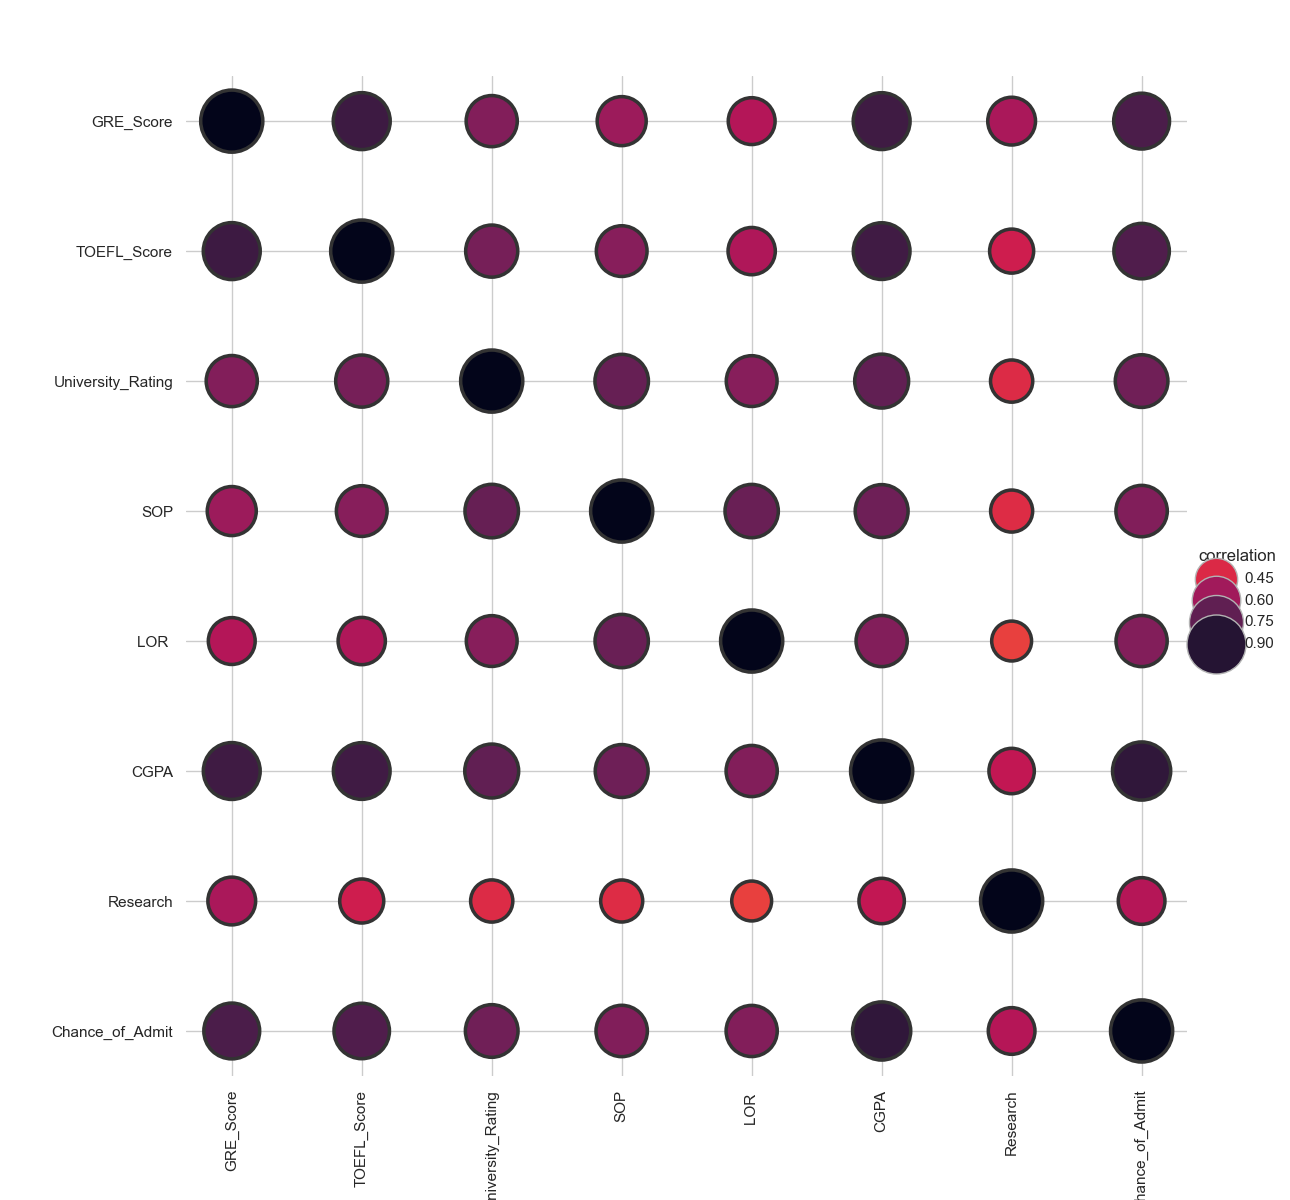

In [16]:
# Make a seaborn cross-correlation scatter plot
%matplotlib widget
sns.set_theme()
sns.set_theme(style="whitegrid")

# Compute a correlation matrix and convert to long-form
corr_mat = in_data.corr().stack().reset_index(name="correlation")

# Draw each cell as a scatter point with varying size and color
g = sns.relplot(
    data=corr_mat,
    x="level_0", y="level_1", hue="correlation", size="correlation",
    palette="rocket_r", hue_norm=(0, 1), edgecolor=".2",
    height=12, sizes=(50, 2000), size_norm=(0, 1), legend='brief'
)

# Tweak the figure to finalize
g.set(xlabel="", ylabel="", aspect="equal")
g.despine(left=True, bottom=True)
g.ax.margins(.05)
for label in g.ax.get_xticklabels():
    label.set_rotation(90)
for artist in g.legend.legendHandles:
    artist.set_edgecolor(".7")


sns.set_theme()

In [17]:
# Make a XGBoost DMatrix object
ytr = in_data['Chance_of_Admit'].values # define y variable
xtr = in_data.drop('Chance_of_Admit', axis=1) # define x variables
xgdata = xgb.DMatrix(xtr, ytr, missing=np.NaN) # y values are the 'labels' of a DMatrix

In [28]:
# split data into train and test
from sklearn.model_selection import train_test_split 
X_train, X_test, y_train, y_test = train_test_split(xtr,ytr,test_size = 0.15, random_state = 101) 

In [31]:
# set up parameter grid and interate over XGBoost model pareter sets
from sklearn.model_selection import GridSearchCV
gamme_range = list(np.arange(0, 2, 0.5))
eta_range = list(np.arange(0.05, 0.5, 0.05))
lambda_range = list(np.arange(0.6, 1.4, 0.2))
min_child_weight_range = list(np.arange(1, 21, 5))
max_depth_range = list(np.arange(4, 7 , 1))

param_grid = {'gamma': gamme_range, 'eta' : eta_range , 'reg_lambda' : lambda_range, 'min_child_weight' : min_child_weight_range, 
              'max_depth' : max_depth_range, 'booster' : ['gbtree']}

# this is the scikit-learn XGBoost interface, which allows sklearn functions like .fit() to be used
xgb_model = xgb.XGBRegressor('reg:squarederror')
xgb_model.fit(X_train, y_train) 

# clf stores
xgb_iters = GridSearchCV(xgb_model, param_grid, cv=5, scoring='r2', verbose=1, refit=True, return_train_score=True)
xgb_iters.fit(X_train, y_train)
print('Best parameter set: %s' % xgb_iters.best_params_) 

C:\Users\xrnogueira\Anaconda3\envs\cartography\lib\site-packages\xgboost\core.py:430: FutureWarning: Pass `objective` as keyword args.  Passing these as positional arguments will be considered as error in future releases.
  warnings.warn(


Fitting 5 folds for each of 1920 candidates, totalling 9600 fits
Best parameter set: {'booster': 'gbtree', 'eta': 0.0, 'gamma': 0.0, 'max_depth': 4, 'min_child_weight': 1, 'reg_lambda': 0.8}


Text(0, 0.5, 'Actual Admission Rate')

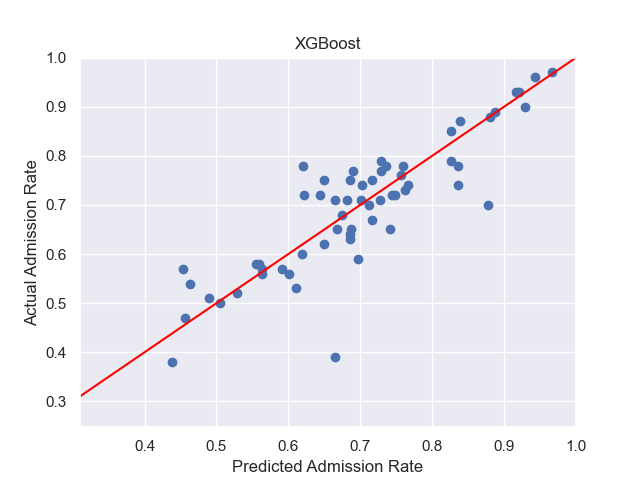

In [32]:
# print best parameter after tuning 
%matplotlib widget
grid_predictions = xgb_iters.predict(X_test) 

plt.scatter(grid_predictions, y_test)
plt.title('XGBoost')
plt.plot(np.arange(0, 1.1, 0.1), np.arange(0, 1.1, 0.1), c='red')
plt.xlim(np.min(grid_predictions) - np.std(grid_predictions), 1)
plt.ylim(np.min(y_test) - np.std(y_test), 1)
plt.xlabel('Predicted Admission Rate')
plt.ylabel('Actual Admission Rate')

In [34]:
# calculate performance metrics
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error

print('R2 = %s' % r2_score(y_test, grid_predictions))
print('mean_sqrd_error = %s' % mean_squared_error(y_test, grid_predictions))

R2 = 0.7482561066935726
mean_sqrd_error = 0.0044227136393524945


### Compare with multiple regression 
Which we also need to code for the ADDRESS method residual calculations

In [35]:
# set up multiple regression model
from sklearn.linear_model import LinearRegression

linear_model = LinearRegression()
linear_model.fit(X_train, y_train)

LinearRegression()

Text(0, 0.5, 'Actual Admission Rate')

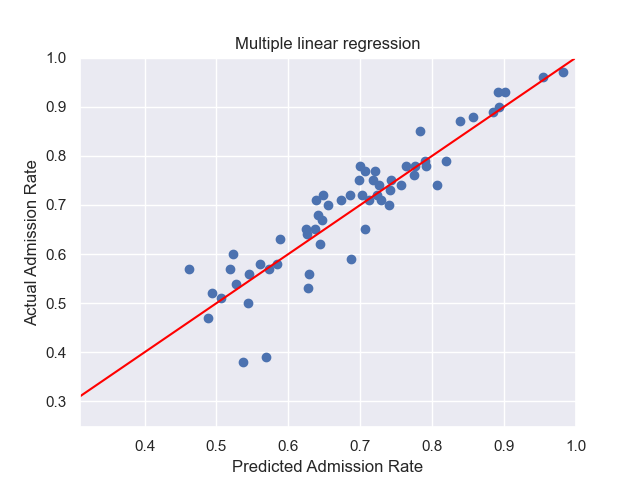

In [36]:
# plot multiple regression fit
%matplotlib widget
linear_predictions = linear_model.predict(X_test) 

plt.scatter(linear_predictions, y_test)
plt.title('Multiple linear regression')
plt.plot(np.arange(0, 1.1, 0.1), np.arange(0, 1.1, 0.1), c='red')
plt.xlim(np.min(grid_predictions) - np.std(grid_predictions), 1)
plt.ylim(np.min(y_test) - np.std(y_test), 1)
plt.xlabel('Predicted Admission Rate')
plt.ylabel('Actual Admission Rate')

In [37]:
# calculate performance metrics
print('R2 = %s' % r2_score(y_test, linear_predictions))
print('mean_sqrd_error = %s' % mean_squared_error(y_test, linear_predictions))

R2 = 0.8467278264521583
mean_sqrd_error = 0.002692732378052623
